# Visualization of PV Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Quick Look

In [2]:
pv_dataset = pd.read_csv("PV_dataset.csv")
pv_dataset.head()

,module_name,timestamp,Vmpp,Impp,Pmpp,Isc,Voc,FF,Rsh,Rs,...,G_refl_start,G_refl_end,module_temperature_center,module_temperature_lateral,air_temperature,relative_humidity,air_density,abs_pressure,wind_speed_ms,wind_direction
0,VBHN330,2022-01-01 06:30:01,44.721021,0.113265,5.065330,0.307710,215.459507,0.076401,36.111069,1506.503102,...,3.20,3.19,21.17,20.38,19.17,95.08,1.19,1003.87,0.53,317.01
1,NAF128GK,2022-01-01 06:30:37,36.339943,0.058908,2.140718,0.107974,47.480906,0.417562,191.061792,104.088283,...,3.36,3.42,20.87,20.09,19.19,95.05,1.19,1003.95,1.35,40.54
2,QPEAK315,2022-01-01 06:31:16,29.964212,0.195919,5.870553,0.420008,34.860217,0.400951,26.414298,15.247258,...,3.42,3.51,20.37,20.05,19.19,95.05,1.19,1003.95,0.59,339.69
3,LG370Q1C,2022-01-01 06:31:35,29.967451,0.185282,5.552421,0.463826,36.688569,0.326285,24.364856,19.248764,...,3.54,3.51,22.06,20.67,19.26,95.17,1.19,1003.89,0.46,320.94
4,LG345N1C,2022-01-01 06:31:53,30.807138,0.216801,6.679021,0.504668,36.065147,0.366960,20.283403,14.490173,...,3.55,3.48,20.88,NaN,19.26,95.17,1.19,1003.89,0.64,321.56


### Samples per PV module per month 

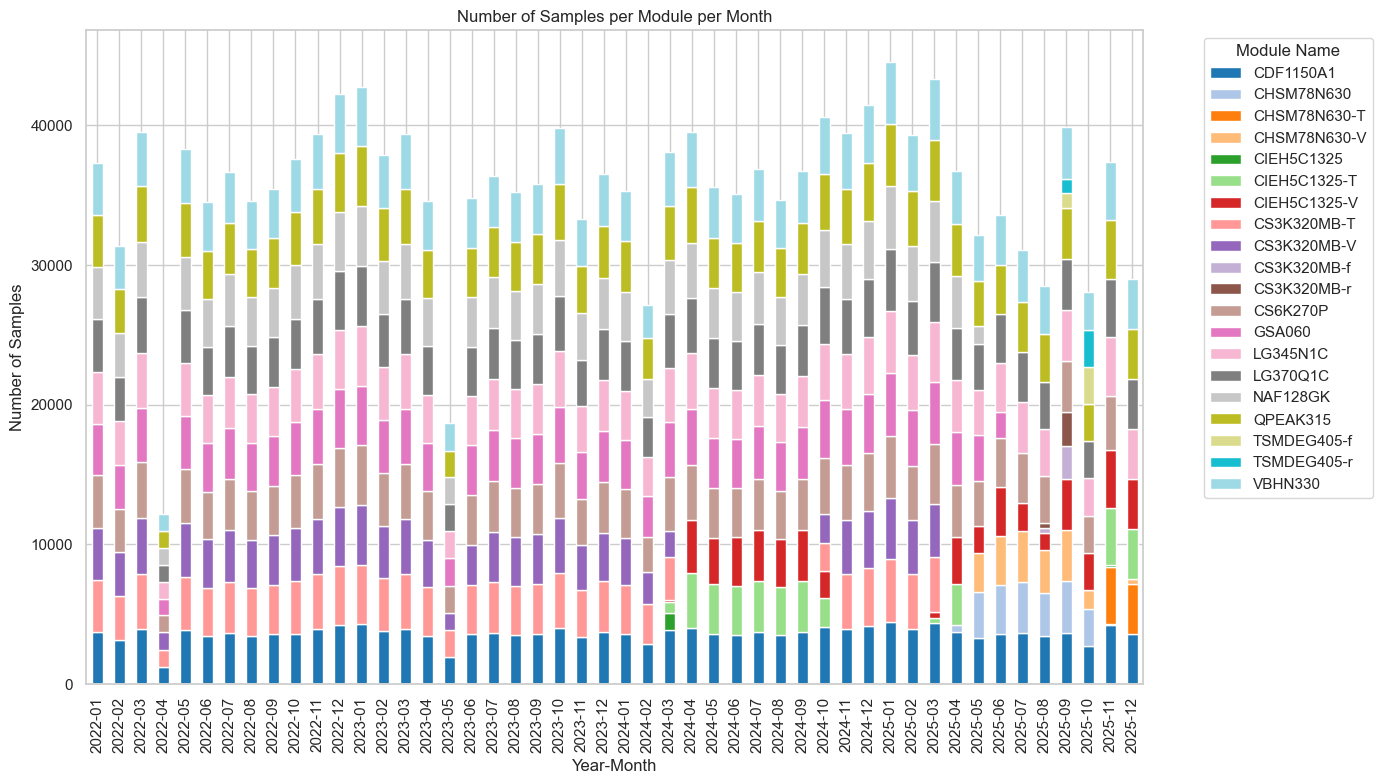

In [10]:
df = pv_dataset[['module_name', 'timestamp']].copy()
df['month_year'] = pd.to_datetime(df['timestamp']).dt.to_period('M').astype(str)
df = df.groupby(['month_year', 'module_name']).size().reset_index(name='count').sort_values('month_year')
df = df.pivot(index='month_year', columns='module_name', values='count').fillna(0)

df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.legend(title='Module Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Module per Month')
plt.tight_layout()
# Force the window to show
plt.show()


## Data Quality: Missing values

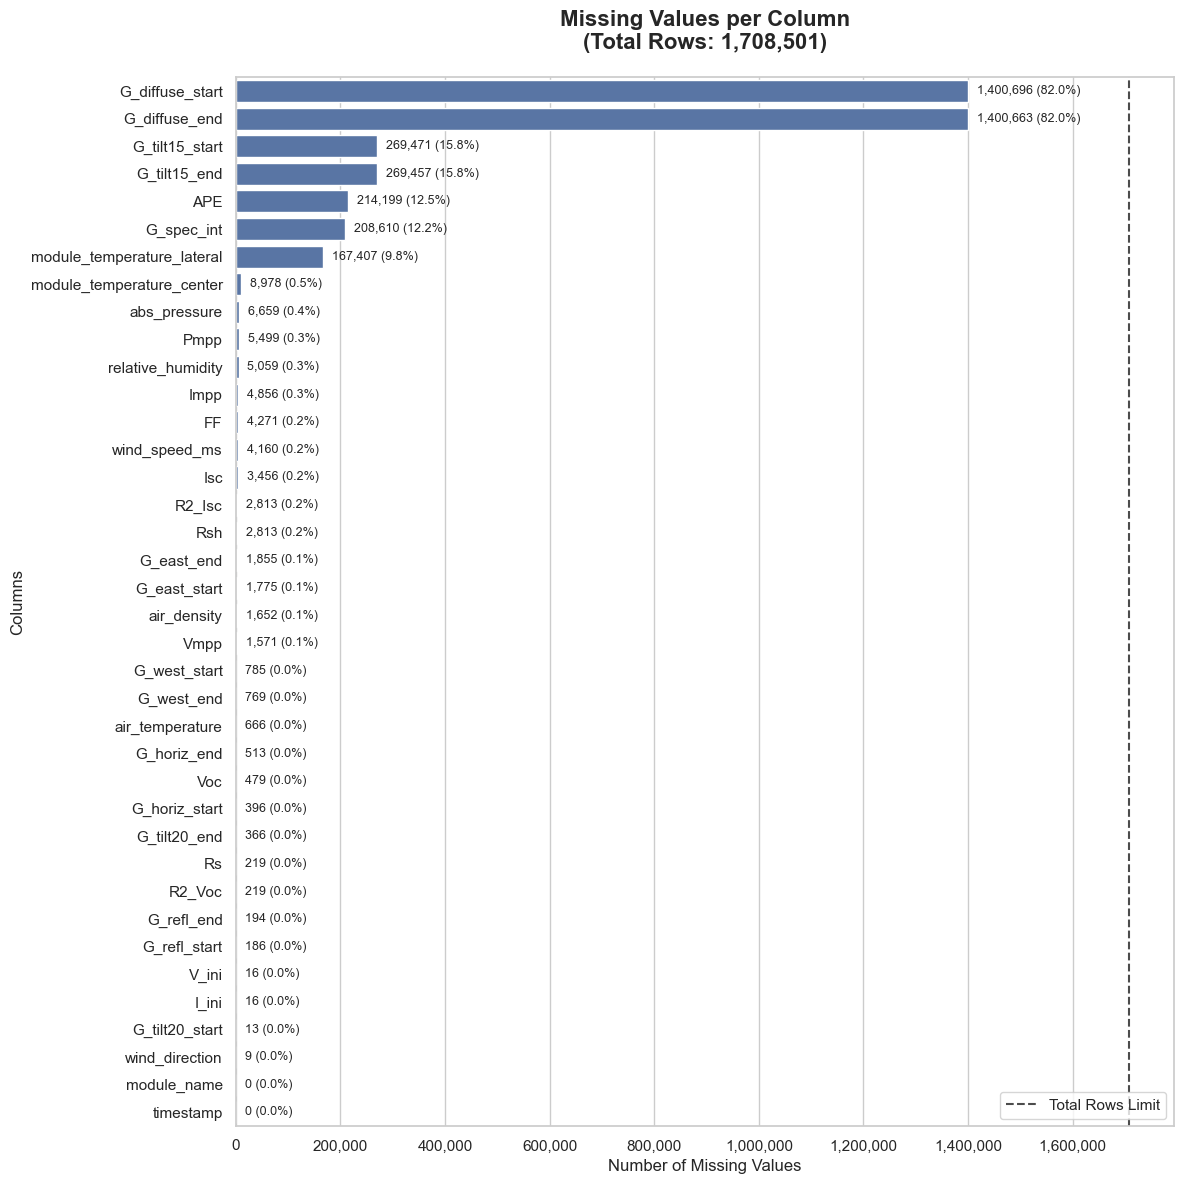

In [4]:
# Prepare the data
missing_data = pv_dataset.isna().sum().sort_values(ascending=False)
total_rows = len(pv_dataset) 
df_missing = missing_data.reset_index()
df_missing.columns = ['Column', 'MissingCount']
df_missing['Percentage'] = (df_missing['MissingCount'] / total_rows) * 100

# Set up the figure
plt.figure(figsize=(12, 12)) # Tall figure for 38 columns
sns.set_theme(style="whitegrid")

ax = sns.barplot(y='Column', x='MissingCount', data=df_missing)

# Format X-axis with commas (e.g., 1,000,000)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add Titles and Labels
plt.title(f"Missing Values per Column\n(Total Rows: {total_rows:,})", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Number of Missing Values", fontsize=12)
plt.ylabel("Columns", fontsize=12)

# Add Data Labels (Count and Percentage)
for i, p in enumerate(ax.patches):
    width = p.get_width()
    pct = df_missing.iloc[i]['Percentage']
    
    # Text formatting: Add comma to count and 1 decimal to percentage
    label_text = f'{int(width):,} ({pct:.1f}%)'
    
    # If the bar is too short, place text outside; otherwise, place inside
    ax.text(width + total_rows*0.01, p.get_y() + p.get_height()/2, label_text, va='center', fontsize=9)

# 8. Add a reference line for the total row limit
plt.axvline(total_rows, color='black', linestyle='--', alpha=0.7, label='Total Rows Limit')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [5]:
# Print as latex table
df_filtered = df_missing[df_missing['MissingCount'] > 0].copy()
df_filtered.columns = ['Feature Name', 'Count', 'Missing (%)']

# 2. ESCAPE UNDERSCORES: This turns G_diffuse into G\_diffuse
df_filtered['Feature Name'] = df_filtered['Feature Name'].str.replace('_', r'\_', regex=False)

latex_str = df_filtered.to_latex(
    index=False,
    column_format='|l|c|r|',
    escape=False, # Allows us to use the \% we added above
    float_format="%.2f"
)

# 3. Clean the rules to match the "all \hline" style of your template
# This replaces the default booktabs rules with standard table lines
latex_str = (latex_str.replace('\\toprule', '\\hline')
                      .replace('\\midrule', '\\hline')
                      .replace('\\bottomrule', '\\hline'))

# 4. Wrap in your specific table environment
template_table = f"""\\begin{{table}}
\\caption{{Summary of missing data in the dataset}}
\\setlength{{\\tabcolsep}}{{3pt}}
{latex_str}\\label{{tab:missing_data}}
\\end{{table}}"""

print(template_table)

\begin{table}
\caption{Summary of missing data in the dataset}
\setlength{\tabcolsep}{3pt}
\begin{tabular}{|l|c|r|}
\hline
Feature Name & Count & Missing (%) \\
\hline
G\_diffuse\_start & 1400696 & 81.98 \\
G\_diffuse\_end & 1400663 & 81.98 \\
G\_tilt15\_start & 269471 & 15.77 \\
G\_tilt15\_end & 269457 & 15.77 \\
APE & 214199 & 12.54 \\
G\_spec\_int & 208610 & 12.21 \\
module\_temperature\_lateral & 167407 & 9.80 \\
module\_temperature\_center & 8978 & 0.53 \\
abs\_pressure & 6659 & 0.39 \\
Pmpp & 5499 & 0.32 \\
relative\_humidity & 5059 & 0.30 \\
Impp & 4856 & 0.28 \\
FF & 4271 & 0.25 \\
wind\_speed\_ms & 4160 & 0.24 \\
Isc & 3456 & 0.20 \\
R2\_Isc & 2813 & 0.16 \\
Rsh & 2813 & 0.16 \\
G\_east\_end & 1855 & 0.11 \\
G\_east\_start & 1775 & 0.10 \\
air\_density & 1652 & 0.10 \\
Vmpp & 1571 & 0.09 \\
G\_west\_start & 785 & 0.05 \\
G\_west\_end & 769 & 0.05 \\
air\_temperature & 666 & 0.04 \\
G\_horiz\_end & 513 & 0.03 \\
Voc & 479 & 0.03 \\
G\_horiz\_start & 396 & 0.02 \\
G\_tilt20\_end

# Ambient variables

In [6]:
elec_cols = ['Vmpp', 'Impp', 'Pmpp', 'Voc', 'Isc', 'FF', 'Rsh', 'Rs', 'R2_Isc', 'R2_Voc', 'V_ini', 'I_ini']
df_ambient = pv_dataset.drop(columns=['module_name', 'timestamp'] + elec_cols)

### Distribution (histplots)

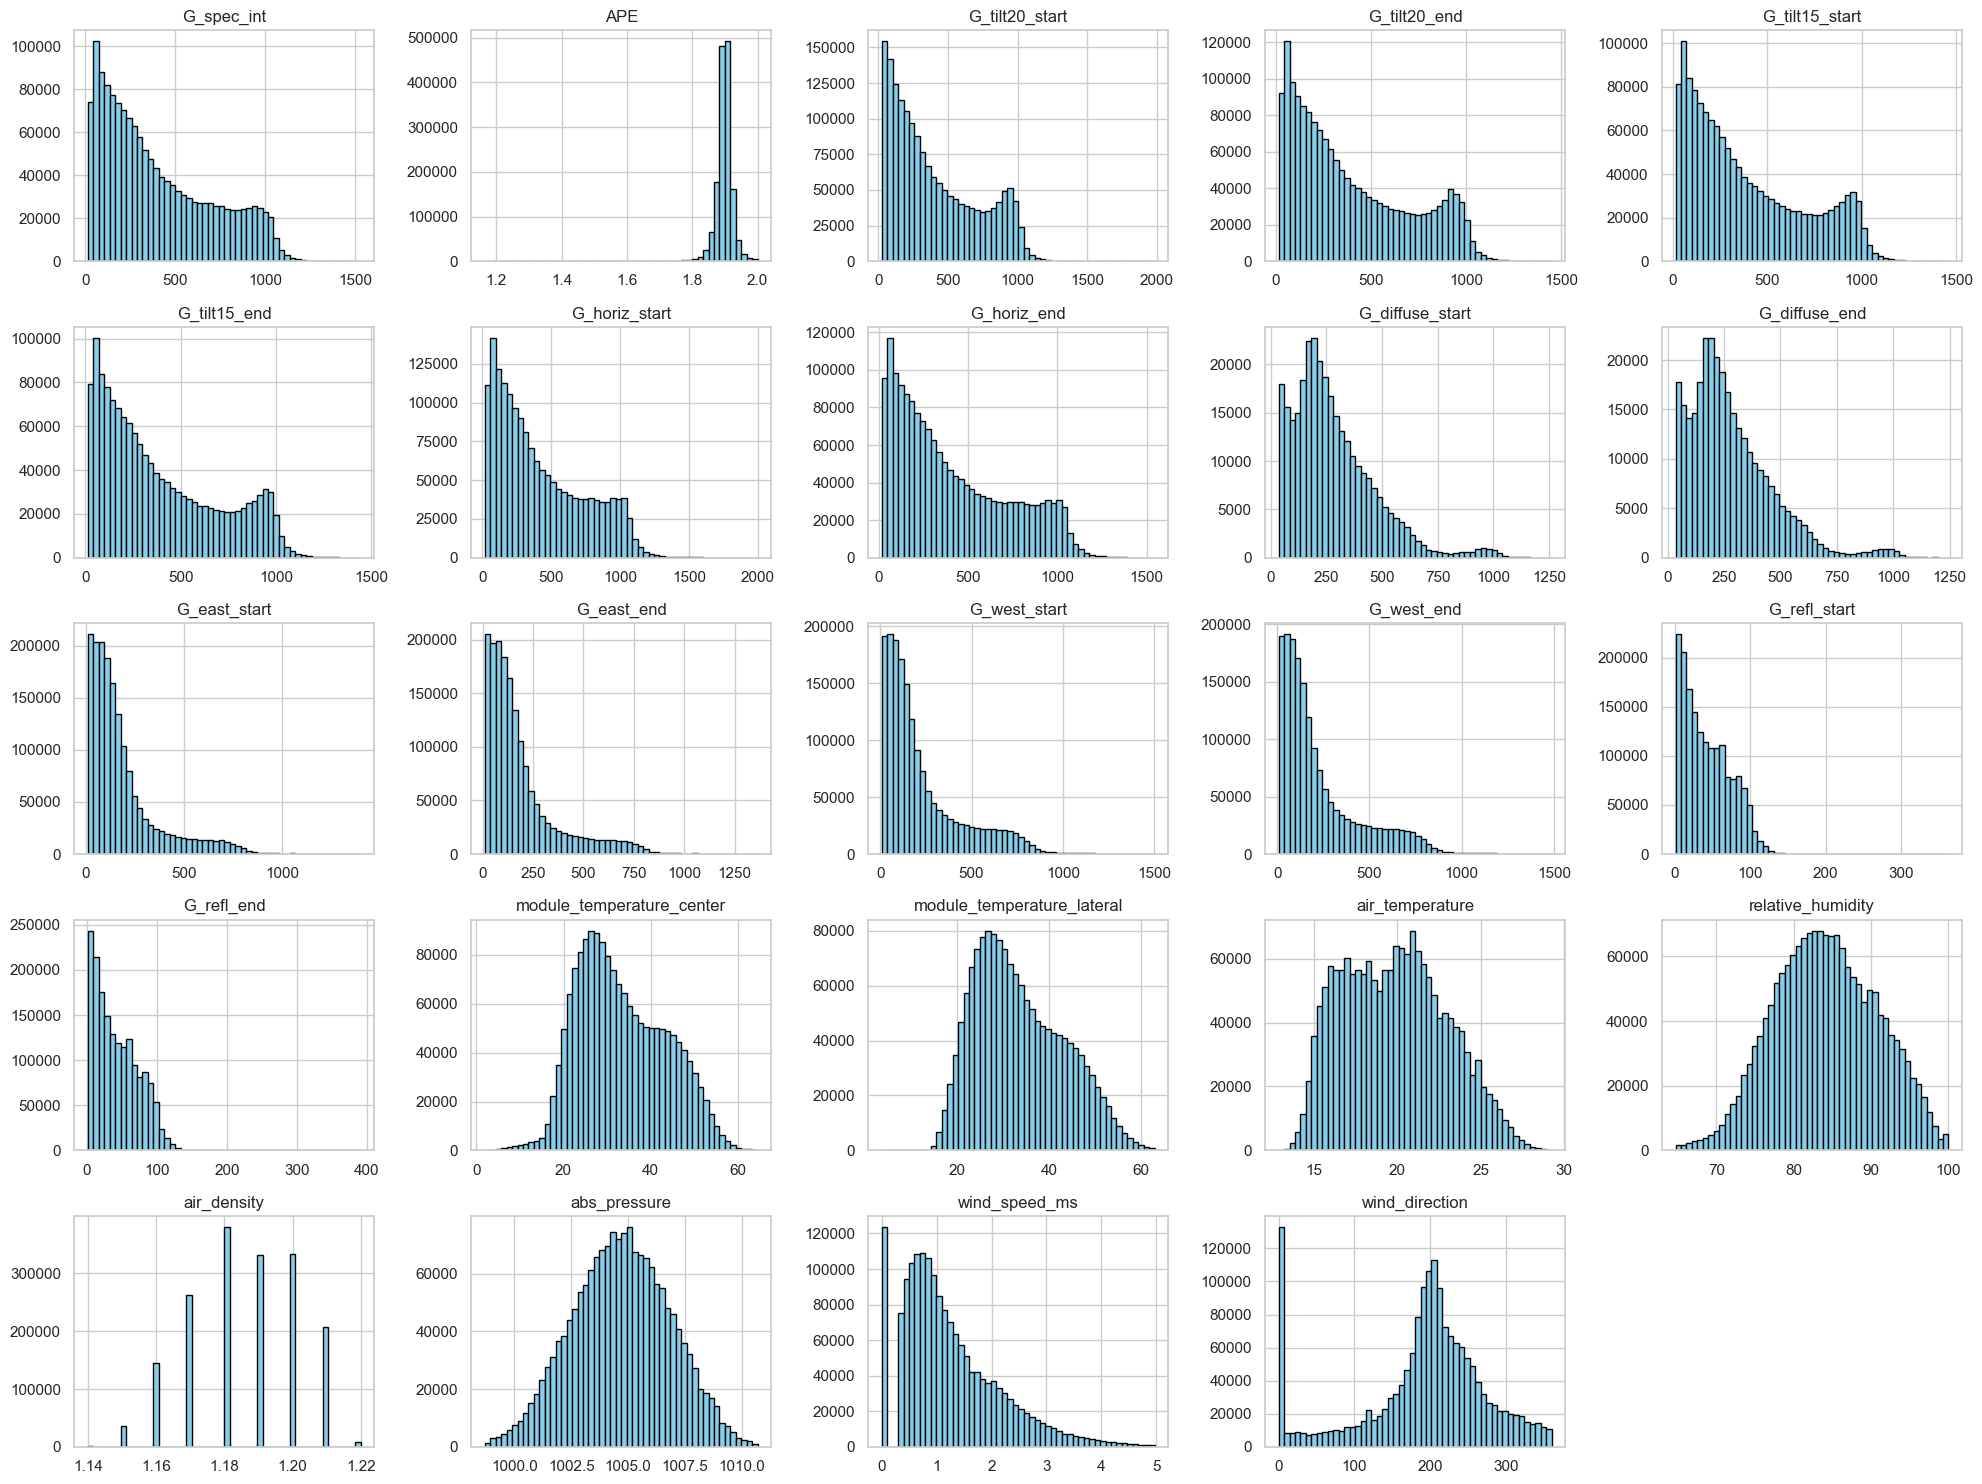

In [7]:
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [8]:
df_ambient.describe().T

,count,mean,std,min,25%,50%,75%,max
G_spec_int,1499891.0,398.173618,299.162026,13.451335,145.604483,313.914221,615.306843,1529.526324
APE,1494302.0,1.897941,0.024143,1.164473,1.887453,1.899206,1.910029,2.000000
G_tilt20_start,1708488.0,401.489565,302.665194,23.220000,143.050000,312.120000,630.262500,1982.440000
G_tilt20_end,1708135.0,394.834336,302.379522,13.210000,136.570000,305.460000,623.650000,1450.160000
G_tilt15_start,1439030.0,390.242248,300.715799,13.150000,134.660000,301.090000,611.490000,1460.320000
G_tilt15_end,1439044.0,390.347798,300.696740,13.140000,134.760000,301.190000,611.680000,1444.120000
G_horiz_start,1708105.0,421.101911,315.166525,16.720000,153.590000,331.070000,654.510000,1999.560000
G_horiz_end,1707988.0,409.265563,310.200797,14.950000,145.460000,320.850000,640.560000,1544.920000
G_diffuse_start,307805.0,280.825921,183.256119,34.960000,152.260000,240.040000,374.180000,1261.210000
G_diffuse_end,307838.0,280.791502,183.246497,34.950000,152.250000,240.030000,374.180000,1245.260000


### Electrical variables

In [ ]:
df_electrical = pv_dataset[elec_cols + ['module_name']].copy()
df_electrical['Pmpp'] = df_electrical[df_electrical['Pmpp'] < 1000]['Pmpp']
order = df_electrical.groupby("module_name")["Pmpp"].median().sort_values().index
modules_metadata = pd.read_csv("modules_metadata.csv", index_col='module_name')

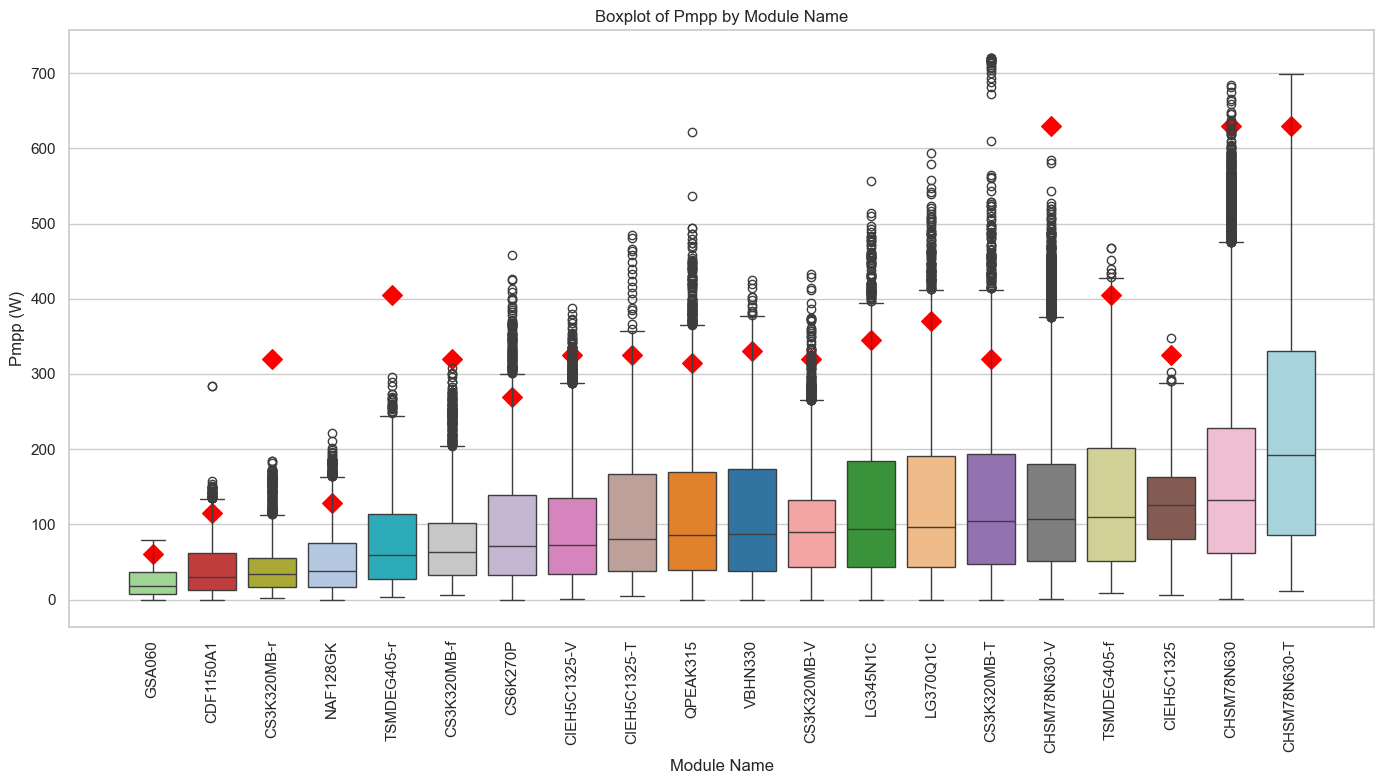

In [109]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='module_name', hue='module_name', y='Pmpp', data=df_electrical, palette='tab20', legend=False, order=order)
plt.scatter(x=range(len(order)), y=modules_metadata.loc[order, 'Pmpp_stc'], color='red', marker='D', s=100, label='Pmpp @ STC')
plt.xticks(rotation=90)
plt.xlabel('Module Name')
plt.ylabel('Pmpp (W)')
plt.title('Boxplot of Pmpp by Module Name')
plt.tight_layout()
plt.show()